In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline # plot in cell
from sklearn import metrics
import pandas as pd
from scipy import signal
from scipy import stats

import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# for svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

In [2]:
import pandas as pd

data = pd.read_excel(r'F:\Program\OneDrive\TLNC\ISI\data\data.xlsx')
data.columns
data

Index(['Person', 'State', 'x', 'y', 'z'], dtype='object')

,Person,State,x,y,z
0,33.0,Jogging,-0.694638,12.680544,0.503953
1,33.0,Jogging,5.012288,11.264028,0.953424
2,33.0,Jogging,4.903325,10.882658,-0.081722
3,33.0,Jogging,-0.612916,18.496431,3.023717
4,33.0,Jogging,-1.184970,12.108489,7.205164
...,...,...,...,...,...
1048570,7.0,Standing,-8.080000,5.090000,-0.690000
1048571,7.0,Standing,-8.120000,5.520000,-0.800000
1048572,7.0,Standing,-7.890000,5.790000,-0.720000
1048573,7.0,Standing,-7.890000,5.980000,-0.270000


In [3]:
G = 9.81
data['x'] = data['x'].div(G)
data['y'] = data['y'].div(G)
data['z'] = data['z'].div(G)
data

,Person,State,x,y,z
0,33.0,Jogging,-0.070809,1.292614,0.051371
1,33.0,Jogging,0.510937,1.148219,0.097189
2,33.0,Jogging,0.499829,1.109343,-0.008330
3,33.0,Jogging,-0.062479,1.885467,0.308228
4,33.0,Jogging,-0.120792,1.234301,0.734471
...,...,...,...,...,...
1048570,7.0,Standing,-0.823649,0.518858,-0.070336
1048571,7.0,Standing,-0.827727,0.562691,-0.081549
1048572,7.0,Standing,-0.804281,0.590214,-0.073394
1048573,7.0,Standing,-0.804281,0.609582,-0.027523


In [4]:
data = data.drop(columns = 'Person')
df = data.groupby(['State'])
df.first()

,x,y,z
State,,,
Downstairs,-0.004165,0.508160,0.663662
Jogging,-0.070809,1.292614,0.051371
Sitting,0.265036,0.984709,0.105520
Standing,-0.191641,1.004077,-0.023603
Upstairs,1.031592,0.441516,-0.385979
Walking,0.086082,0.816388,0.284625


In [5]:
STN = df.get_group(('Downstairs'))
JOG = df.get_group(('Jogging'))
SIT = df.get_group(('Sitting'))
STD = df.get_group(('Standing'))
STU = df.get_group(('Upstairs'))
WAL = df.get_group(('Walking'))

len(STN)
len(JOG)
len(SIT)
len(STD)
len(STU)
len(WAL)

97813

325975

54876

44541

118589

406776

In [6]:
STD.isnull().sum().sum()
WAL.isnull().sum().sum()
SIT.isnull().sum().sum()
JOG.isnull().sum().sum()
STU.isnull().sum().sum()
STN.isnull().sum().sum()

0

1

0

0

0

0

In [7]:
#Check nan value & remove 
len(WAL.index)

WAL = WAL.dropna()
WAL.index = pd.RangeIndex(len(WAL.index))
len(WAL.index)
WAL.isnull().sum().sum()

type(WAL)

406776

406775

0

pandas.core.frame.DataFrame

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Standing')

Text(0.5, 0, 'Samples')

Text(0, 0.5, 'Amplitude')

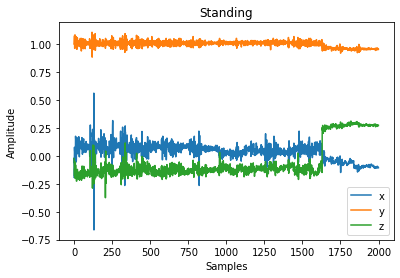

In [9]:
sample = range(0,2000)
plt.figure(1)
plt.plot(sample,STD[0:2000])
plt.title('Standing')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend(["x","y","z"])

20 samples -> 1 new sample (= cách lấy trung bình) 
10 new samples -> 1 frame 
tính toán features trên frame đó

In [8]:
def arrayMean(array, distance):
    result = []
    for i in range(int(np.ceil(len(array)/distance))):
        unitArray = array[i*distance:(i+1)*distance]
        unitMean = np.mean(unitArray)
        result.append(unitMean)
    return pd.DataFrame(result)

Standing = arrayMean(STD, 20)
Walking = arrayMean(WAL, 20)
Sitting = arrayMean(SIT, 20)
Jogging  = arrayMean(JOG, 20)
Upstairs  = arrayMean(STU, 20)
Downstairs  = arrayMean(STN, 20)

In [9]:
len(STD)
len(WAL)
len(SIT)
len(JOG)
len(STU)
len(STN)

44541

406775

54876

325975

118589

97813

In [10]:
len(Standing)
len(Walking)
len(Sitting)
len(Jogging)
len(Upstairs)
len(Downstairs)

2228

20339

2744

16299

5930

4891

STD.isnull().sum().sum()
WAL.isnull().sum().sum()
SIT.isnull().sum().sum()
JOG.isnull().sum().sum()
STU.isnull().sum().sum()
STN.isnull().sum().sum()

In [11]:
# Split dataset to 2 parts: Train (60%) - Test (40%)\n",

window_size = 10
stride = 5 #step

X_stand_train = [Standing[i:i+window_size] for i in range(0, int(len(Standing)*0.6), stride)] 
X_stand_test = [Standing[i:i+window_size] for i in range(int(len(Standing)*0.6), len(Standing), stride) 
                                            if i+window_size<=len(Standing)]

X_walk_train = [Walking[i:i+window_size] for i in range(0, int(len(Walking)*0.6), stride)]
X_walk_test = [Walking[i:i+window_size] for i in range(int(len(Walking)*0.6), len(Walking),stride)
                                           if i+window_size<=len(Walking)]

X_sit_train = [Sitting[i:i+window_size] for i in range(0, int(len(Sitting)*0.6), stride)]
X_sit_test = [Sitting[i:i+window_size] for i in range(int(len(Sitting)*0.6), len(Sitting),stride)
                                           if i+window_size<=len(Sitting)]

X_jog_train = [Jogging[i:i+window_size] for i in range(0, int(len(Jogging)*0.6), stride)] 
X_jog_test = [Jogging[i:i+window_size] for i in range(int(len(Jogging)*0.6), len(Jogging), stride) 
                                            if i+window_size<=len(Jogging)]

X_up_train = [Upstairs[i:i+window_size] for i in range(0, int(len(Upstairs)*0.6), stride)] 
X_up_test = [Upstairs[i:i+window_size] for i in range(int(len(Upstairs)*0.6), len(Upstairs), stride) 
                                            if i+window_size<=len(Upstairs)]

X_down_train = [Downstairs[i:i+window_size] for i in range(0, int(len(Downstairs)*0.6), stride)] 
X_down_test = [Downstairs[i:i+window_size] for i in range(int(len(Downstairs)*0.6), len(Downstairs), stride) 
                                            if i+window_size<=len(Downstairs)]

print ('X_stand_train: ', len(X_stand_train))
print ('X_stand_test: ', len(X_stand_test))

print ('X_walk_train: ', len(X_walk_train))
print ('X_walk_test: ', len(X_walk_test))

print ('X_sit_train: ', len(X_sit_train))
print ('X_sit_test: ', len(X_sit_test))

print ('X_jog_train: ', len(X_jog_train))
print ('X_jog_test: ', len(X_jog_test))

print ('X_up_train: ', len(X_up_train))
print ('X_up_test: ', len(X_up_test))

print ('X_down_train: ', len(X_down_train))
print ('X_down_test: ', len(X_down_test))

X_stand_train:  268
X_stand_test:  177
X_walk_train:  2441
X_walk_test:  1626
X_sit_train:  330
X_sit_test:  218
X_jog_train:  1956
X_jog_test:  1303
X_up_train:  712
X_up_test:  473
X_down_train:  587
X_down_test:  390


In [12]:
train_data = []
train_label = []

test_data = []
test_label = []

for acts in X_stand_train:
    train_data.append(acts)
    train_label.append(0)
    
for acts in X_walk_train:
    train_data.append(acts)
    train_label.append(1)

for acts in X_sit_train:
    train_data.append(acts)
    train_label.append(2)
    
for acts in X_jog_train:
    train_data.append(acts)
    train_label.append(3)

for acts in X_up_train:
    train_data.append(acts)
    train_label.append(4)

for acts in X_down_train:
    train_data.append(acts)
    train_label.append(5)


print('train-data length: ', len(train_data) )
print('train-label length: ', len(train_label) )
#print(train_label)
      
# For TEST

for acts in X_stand_test:
    test_data.append(acts)
    test_label.append(0)

for acts in X_walk_test:
    test_data.append(acts)
    test_label.append(1)

for acts in X_sit_test:
    test_data.append(acts)
    test_label.append(2)
        
for acts in X_jog_test:
    test_data.append(acts)
    test_label.append(3)

for acts in X_up_test:
    test_data.append(acts)
    test_label.append(4)

for acts in X_down_test:
    test_data.append(acts)
    test_label.append(5)

print('test-data length: ', len(test_data))
print('test-label length: ', len(test_label))

train-data length:  6294
train-label length:  6294
test-data length:  4187
test-label length:  4187


target_names = ['Standing', 'Walking', 'Sitting', 'Jogging']

def averageAbsolute(arr):
    result = []
    for i in arr:
        differAbsolute = i - np.mean(arr)
        result = np.append(result,abs(differAbsolute))
    return np.mean(result)

def averageResultant(x, y, z):
    ans = np.array([])
    for i,j,k in zip(x, y, z):
        x = np.sqrt(i*i+j*j+k*k)
        ans = np.append(ans,x)
    return np.mean(ans)

def featuresFromBuffer(at):
    feat = np.zeros(32)    
    
    x = np.array(at.iloc[:,0], dtype=np.float64)   
    y = np.array(at.iloc[:,1], dtype=np.float64)   
    z = np.array(at.iloc[:,2], dtype=np.float64)  
    
    means = [np.mean(i) for i in [x, y, z]]
    feat[0:3] = means 
    
    rms = [np.sqrt(np.mean(i**2)) for i in [x, y, z]]
    feat[3:6] = rms

    std = [np.std(i) for i in [x, y, z]]
    feat[6:9] = std

    med = [np.median(i) for i in [x, y, z]]
    feat[9:12] = med

    Range1 = [ np.amin(i) for i in [x, y, z]]    
    feat[12:15] = Range1
    Range2 = [ np.amax(i) for i in [x, y, z]]    
    feat[15:18] = Range2
    
    #average Absolute
    averAbs = [averageAbsolute(i) for i in [x,y,z]]
    feat[18:21] = averAbs
    
    #averageResultant
    feat[21] = averageResultant(x, y, z)
    
    #var
    var = [np.var(i) for i in [x, y, z]]
    feat[22:25] = var
    
    # pearsonr correlation
    x_pd = pd.Series(x)
    y_pd = pd.Series(y)
    z_pd = pd.Series(z)
    Pearsonr_xy = x_pd.corr(y_pd)
    feat[26] = Pearsonr_xy
    Pearsonr_yz = y_pd.corr(z_pd)
    feat[27] = Pearsonr_yz
    Pearsonr_zx = z_pd.corr(x_pd)
    feat[28] = Pearsonr_zx
    
    #mad
    mad = [stats.median_absolute_deviation(i) for i in [x, y, z]]   
    feat[29:32] = mad
    return feat  

In [13]:
# 5 features: mean, sd, rms, median, range

def featuresFromBuffer(at):
    feat = np.zeros(15)    
    
    x = np.array(at.iloc[:,0], dtype=np.float64)   
    y = np.array(at.iloc[:,1], dtype=np.float64)   
    z = np.array(at.iloc[:,2], dtype=np.float64)  
    
    means = [np.mean(i) for i in [x, y, z]]
    feat[0:3] = means 
    
    rms = [np.sqrt(np.mean(i**2)) for i in [x, y, z]]
    feat[3:6] = rms

    sd = [np.std(i) for i in [x, y, z]]
    feat[6:9] = sd

    med = [np.median(i) for i in [x, y, z]]
    feat[9:12] = med

    Range = [np.amax(i)-np.amin(i) for i in [x, y, z]]    
    feat[12:15] = Range

    return feat  

In [14]:
# Tạo mảng features 

train_features = []
test_features = []
for action in train_data:
    feat = featuresFromBuffer(action)
    train_features.append(feat)  

for action in test_data:
    feat = featuresFromBuffer(action)
    test_features.append(feat)

len(train_features)
len(test_features)

6294

4187

In [15]:
#lower accuracy (nan value -> 0)
np.where(np.isnan(train_features)) 
train_features = np.nan_to_num(train_features)
np.where(np.isnan(test_features))
test_features = np.nan_to_num(test_features)      

len(train_features)
len(train_label)

(array([], dtype=int64), array([], dtype=int64))

(array([], dtype=int64), array([], dtype=int64))

6294

6294

In [16]:
#Classifier 

from sklearn.feature_selection import SelectFromModel
print("Gradient Boosting Decision Tree:")
from sklearn.ensemble import GradientBoostingClassifier
clf1 = GradientBoostingClassifier(learning_rate=0.05,max_depth=3,n_estimators=100).fit(train_features, train_label)
#format: pass score in {:.3f}
print('Accuracy of GBDT classifier on training set: {:.3f}'
     .format(clf1.score(train_features, train_label)))
print('Accuracy of GBDT classifier on test set: {:.3f}'
     .format(clf1.score(test_features, test_label)))

print("\n\nDecision Tree:") 
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree 

clf2 = DecisionTreeClassifier(max_depth=4).fit(train_features, train_label)

print('Accuracy of Decision Tree classifier on training set: {:.3f}'.format(clf2.score(train_features, train_label)))
print('Accuracy of Decision Tree classifier on test set: {:.3f}'
.format(clf2.score(test_features, test_label)))


print("\n\nSVM:")
clf3 = SVC(C=100, gamma='scale').fit(train_features, train_label)
print("Accuracy on training set: {:.2f}".format(clf3.score(train_features, train_label)))
print("Accuracy on test set: {:.2f}".format(clf3.score(test_features, test_label)))


print('\n\n Random Forests: ')
from sklearn.ensemble import RandomForestClassifier
clf4 = RandomForestClassifier(n_estimators=200, random_state=0).fit(train_features, train_label)

print('Accuracy of RF classifier on training set: {:.3f}'
     .format(clf4.score(train_features, train_label)))
print('Accuracy of RF classifier on test set: {:.3f}'
     .format(clf4.score(test_features, test_label)))


print('\n\n KNeighbor: ')
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance').fit(train_features, train_label)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(train_features, train_label)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(test_features, test_label)))


Gradient Boosting Decision Tree:
Accuracy of GBDT classifier on training set: 0.903
Accuracy of GBDT classifier on test set: 0.649


Decision Tree:
Accuracy of Decision Tree classifier on training set: 0.769
Accuracy of Decision Tree classifier on test set: 0.599


SVM:
Accuracy on training set: 0.90
Accuracy on test set: 0.63


 Random Forests: 
Accuracy of RF classifier on training set: 1.000
Accuracy of RF classifier on test set: 0.643


 KNeighbor: 
Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.56


<Figure size 560x400 with 0 Axes>

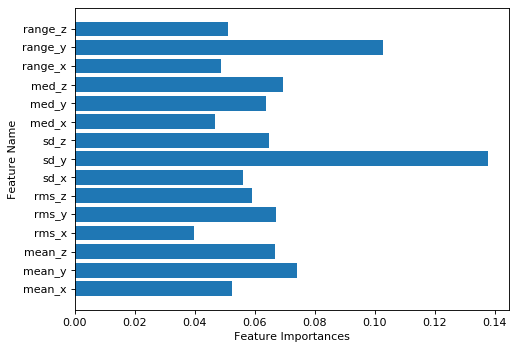

Feature importances: [0.05245891 0.07419353 0.06669168 0.03979793 0.06703783 0.05900867
 0.05591335 0.13774285 0.06463039 0.04672055 0.0637317  0.06942002
 0.04876582 0.10279663 0.05109013]


In [17]:
# adspy_shared_utilities import plot_feature_importances
# Atturibute Feature importances only use for classifiers contain trees

# feature_names = ['mean_x', 'mean_y', 'mean_z', 
#                 'rms_x', 'rms_y', 'rms_z',
#                 'std_x', 'std_y', 'std_z',
#                 'med_x', 'med_y', 'med_z',
#                 'min_x', 'min_y', 'min_z',
#                 'max_x', 'max_y', 'max_z',
#                 'averAbs_x', 'averAbs_y', 'averAbs_z',
#                 'averMag', 'var_x','var_y','var_z',
# #                'corr_x','corr_y','corr_z',
#                 'mad_x', 'mad_y', 'mad_z']

feature_names = ['mean_x', 'mean_y', 'mean_z', 
                'rms_x', 'rms_y', 'rms_z',
                'sd_x', 'sd_y', 'sd_z',
                'med_x', 'med_y', 'med_z',
                'range_x','range_y','range_z']

def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature Importances")
    plt.ylabel("Feature Name")
    plt.yticks(np.arange(c_features), feature_names)
    
plt.figure(figsize=(7,5), dpi=80)
plot_feature_importances(clf4, feature_names)
plt.show()

print('Feature importances: {}'.format(clf4.feature_importances_))

In [18]:

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
      
y_pred = clf1.predict(test_features)
f1_score(test_label, y_pred, average='macro')
recall_score(test_label, y_pred, average='macro')
precision_score(test_label, y_pred, average='macro',labels=np.unique(y_pred))

f1_score(test_label, y_pred, average='micro')
recall_score(test_label, y_pred, average='micro')
precision_score(test_label, y_pred, average='micro',labels=np.unique(y_pred))

0.5724964032135775

0.5593507861225026

0.5925841085233531

0.649152137568665

0.649152137568665

0.649152137568665

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sb
from sklearn.utils.multiclass import unique_labels

y_pred = clf1.predict(test_features)
lables = np.concatenate([target_names, ])

from sklearn.metrics import f1_score

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False, title=None):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    #metrics.f1_score(y_test, y_pred, labels=np.unique(y_pred))
    
    fig, ax = plt.subplots(figsize = (15,12))
    #Create a 2-dim array include: rows, columns, data
    dataFrame = pd.DataFrame(cm)
    #create a heatmap, annot = True: add text on each cell over heatmap
    sb.heatmap(dataFrame, annot = True)  
    ax.set(xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    sb.set(font_scale = 1.3)

np.set_printoptions(precision=2) #lam tron

plot_confusion_matrix(test_label, y_pred, classes=lables,  
        title='GBDT \nConfusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(test_label, y_pred, classes=lables, normalize=True,
        title='GBDT \nNormalized confusion matrix')

plt.show()
print ("\nClassification Report: ")
print (classification_report(test_label, y_pred,labels=np.unique(y_pred)))


NameError: name 'target_names' is not defined